__Logistic Regression__ is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

## Logistic Regression Assumptions

1. Binary logistic regression requires the dependent variable to be binary.
2. For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
3. Only the meaningful variables should be included.
4. The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
5. The independent variables are linearly related to the log odds.
6. Logistic regression requires quite large sample sizes.

Keeping the above assumptions in mind, let’s look at our dataset.

# Data

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. The classification goal is to predict whether the transaction is fraudulent (1) or not (0) (variable y)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

The dataset includes 284807 records and 31 fields.

In [2]:
data = pd.read_csv("CCFD_Example.csv",encoding='ISO-8859-1')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(284807, 31)
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Input variables

Due to confidentiality issues, Kaggle doesn’t provide the background information about the 28 features out of 30. The only Features defined are ‘Time’ and ‘Amount’. ‘Time’ contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature ‘Amount’ is the Transaction Amount, this feature can be used for example-dependant cost-senstive learning.  

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

#### Predict variable (desired target):

Class - Is the transaction fraudulent? (binary: '1','0')

The Education_Level column of the dataset has many categories. The Education_Level column has the following categories:

After grouping, this is the columns:

# Data exploration

In [4]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

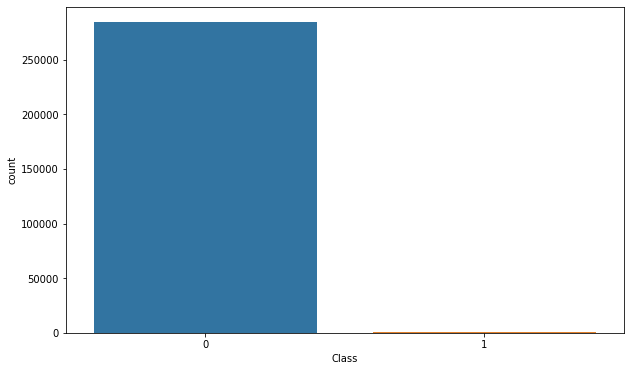

<Figure size 720x432 with 0 Axes>

In [5]:
sns.countplot(x='Class', data=data)
plt.show()
plt.savefig('default_count_plot')

In [6]:
count_no_fraud = len(data[data['Class']==0])
count_fraud = len(data[data['Class']==1])
pct_of_no_fraud = count_no_fraud/(count_no_fraud+count_fraud)
print("\033[1m percentage of no fraud is\033[1m", pct_of_no_fraud*100)
pct_of_fraud = count_fraud/(count_no_fraud+count_fraud)
print("\033[1m percentage of fraud is\033[1m", pct_of_fraud*100)

 percentage of no fraud is 99.82725143693798
 percentage of fraud is 0.1727485630620034


Our classes are imbalanced, and the ratio of no-fraud  to fraud  instances is 99.8:0.2. Before we go ahead to balance the classes, let’s do some more exploration.

# Vizualizations

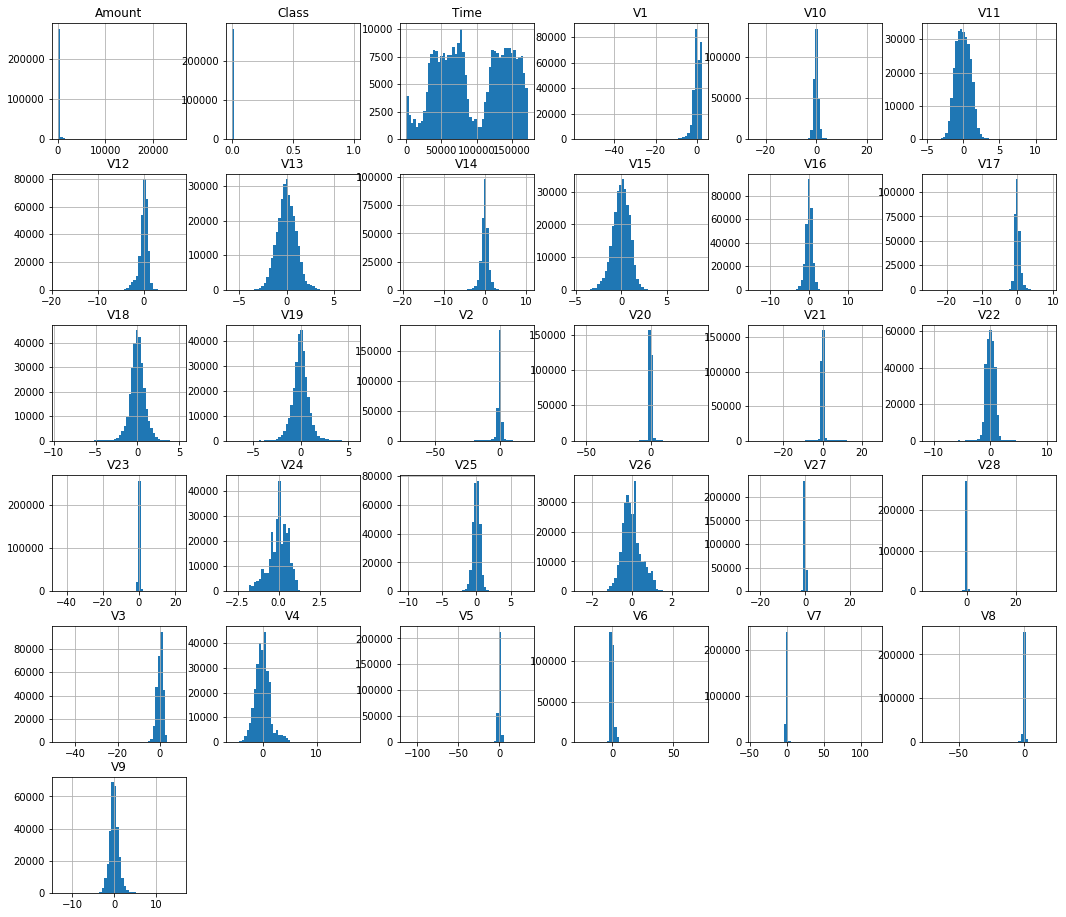

In [7]:
data.hist(bins=50, figsize=(18,16))
plt.show()

# Over-sampling using SMOTE

With our training data created, I’ll up-sample the no-subscription using the __SMOTE algorithm__ (Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.

2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

We are going to implement SMOTE in Python.

In [8]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns1 = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns1)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Class'])
# we can Check the numbers of our data
print("\033[1m length of oversampled data is" ,len(os_data_X))
print("\033[1m Number of no fraud in oversampled data",len(os_data_y[os_data_y['Class']==0]))
print("\033[1m Number of fraud",len(os_data_y[os_data_y['Class']==1]))
print("\033[1m Proportion of no fraud data in oversampled data is ",len(os_data_y[os_data_y['Class']==0])/len(os_data_X))
print("\033[1m Proportion of fraud data in oversampled data is ",len(os_data_y[os_data_y['Class']==1])/len(os_data_X))

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

 length of oversampled data is 398038
 Number of no fraud in oversampled data 199019
 Number of fraud 199019
 Proportion of no fraud data in oversampled data is  0.5
 Proportion of fraud data in oversampled data is  0.5


Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

# Recursive Feature Elimination

__Recursive Feature Elimination (RFE)__ is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [9]:
data_vars=data.columns.values.tolist()
y=['Class']
X=[i for i in data_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[False  True  True False  True  True False False  True  True  True  True
  True  True  True False  True  True  True  True False  True  True False
 False  True False  True  True False]
[10  1  1  2  1  1  3  9  1  1  1  1  1  1  1  7  1  1  1  1  4  1  1  5
  8  1  6  1  1 11]


The RFE has helped us select the following features: 'V1', 'V2', 'V4', 'V5', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'V22', 'V25', 'V27', 'V28'.

In [10]:
cols=['V1', 'V2', 'V4', 'V5', 'V8', 'V9', 'V10', 'V11',
      'V12','V13', 'V14', 'V16', 'V17', 'V18', 'V19',
      'V21', 'V22', 'V25', 'V27', 'V28'] 
X=os_data_X[cols]
y=os_data_y['Class']

# Implementing the model

In [11]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.366619
         Iterations 12
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.471      
Dependent Variable: Class            AIC:              291896.6355
Date:               2020-05-23 00:23 BIC:              292114.5215
No. Observations:   398038           Log-Likelihood:   -1.4593e+05
Df Model:           19               LL-Null:          -2.7590e+05
Df Residuals:       398018           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     12.0000                                       
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
V1        -0.0440     0.0025   -17.2807   0.0000   -0.0490   -0.0390
V2         0.0622     0.0030    20.6223   0.

The p-values for most of the variables are smaller than 0.05, except four variables, therefore, we will remove them.

In [12]:
pvs=['V1', 'V2', 'V4', 'V5', 'V8', 'V9',
     'V10', 'V11', 'V12', 'V13', 'V14',
     'V16', 'V17', 'V18', 'V19', 'V21',
     'V27', 'V28']
X=os_data_X[pvs]
y=os_data_y['Class']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.366621
         Iterations 12
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.471      
Dependent Variable: Class            AIC:              291894.1803
Date:               2020-05-23 00:23 BIC:              292090.2777
No. Observations:   398038           Log-Likelihood:   -1.4593e+05
Df Model:           17               LL-Null:          -2.7590e+05
Df Residuals:       398020           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     12.0000                                       
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
V1        -0.0441     0.0025   -17.3299   0.0000   -0.0491   -0.0391
V2         0.0622     0.0030    20.6349   0.

In [13]:
X=os_data_X[pvs]
y=os_data_y['Class']

# Gradient Boosting Classifier Model Fitting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Predicting the test set results and calculating the accuracy

In [15]:
y_pred = gb.predict(X_test)
print("\033[1m Accuracy of Gradient Boosting Classifier on test set:",
      '{:.2f}'.format(gb.score(X_test, y_test)))

 Accuracy of Gradient Boosting Classifier on test set: 0.99


# Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[59678   373]
 [  989 58372]]


In [17]:
print("\033[1m The result is telling us that we have: ",
      (confusion_matrix[0,0]+confusion_matrix[1,1]),
      "correct predictions\033[1m")
print("\033[1m The result is telling us that we have: ",
      (confusion_matrix[0,1]+confusion_matrix[1,0]),
      "incorrect predictions\033[1m")
print("\033[1m We have a total predictions of: ",
      (confusion_matrix.sum()))

 The result is telling us that we have:  118050 correct predictions
 The result is telling us that we have:  1362 incorrect predictions
 We have a total predictions of:  119412


# Compute precision, recall, F-measure and support

To quote from Scikit Learn:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     60051
           1       0.99      0.98      0.99     59361

    accuracy                           0.99    119412
   macro avg       0.99      0.99      0.99    119412
weighted avg       0.99      0.99      0.99    119412



In [19]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#calculate Accuracy, how often is the classifier correct?
print("Accuracy of Gradient Boosting Classifier model:", "{:.2%}".format(metrics.accuracy_score(y_test, y_pred)))
print("Well, you got a classification rate of", "{:.2%}".format(metrics.accuracy_score(y_test, y_pred)))
#calculate Precision
print("\nPrecision of Gradient Boosting Classifier model:", "{:.2%}".format(metrics.precision_score(y_test, y_pred)))
print("Precision: Precision is about being precise, i.e., how precise your model is. In other words, you can\nsay, when a model makes a prediction, how often it is correct. In our prediction case, when our Gradient\nBoosting Classifier predicted a transaction is a fraudlent, that transaction is actually fraudlent","{:.2%}".format(metrics.precision_score(y_test, y_pred)),"of\n the time.")
#calculate Recall
print("\nRecall of Gradient Boosting Classifier model:", "{:.2%}".format(metrics.recall_score(y_test, y_pred)))
print("Recall: If there is a transaction who is fraudlent present in the test set, our Gradient Boosting Classifier model\ncan identify it", "{:.2%}".format(metrics.recall_score(y_test, y_pred)) ,"of the time.")

Accuracy of Gradient Boosting Classifier model: 98.86%
Well, you got a classification rate of 98.86%

Precision of Gradient Boosting Classifier model: 99.37%
Precision: Precision is about being precise, i.e., how precise your model is. In other words, you can
say, when a model makes a prediction, how often it is correct. In our prediction case, when our Gradient
Boosting Classifier predicted a transaction is a fraudlent, that transaction is actually fraudlent 99.37% of
 the time.

Recall of Gradient Boosting Classifier model: 98.33%
Recall: If there is a transaction who is fraudlent present in the test set, our Gradient Boosting Classifier model
can identify it 98.33% of the time.


# ROC Curve

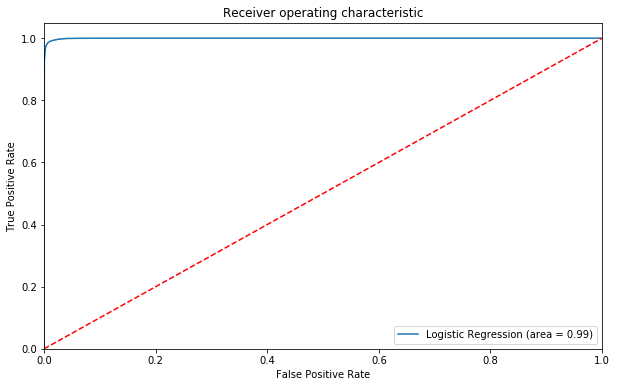

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
gb_roc_auc = roc_auc_score(y_test, gb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % gb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

# Real-time Prediction

In [21]:
data['Prob_to_Fraud'] = gb.predict_proba(data[X_train.columns])[:,1]
data[['Prob_to_Fraud']].head(10)

,Prob_to_Fraud
0,0.108792
1,0.008603
2,0.014960
3,0.004677
4,0.100279
5,0.008595
6,0.005996
7,0.035339
8,0.004416
9,0.028454
